### Process for update_forecast.py

Steps:
1. Scrape new data
2. Process
3. Forecast
4. Output to SQLite


In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np

rcParams['figure.figsize'] = 9, 6

import glob

from sqlalchemy import create_engine


import datetime

In [6]:
# Connecting to Engine
engine = create_engine('sqlite:///nickel_database.sqlite')

connection = engine.connect()

# What's in the database already?
print(engine.table_names())

['LME', 'global_prod', 'inventory', 'upsampled_china', 'upsampled_china_consump']


### Read Data

In [29]:
LME = pd.read_sql_query('SELECT * from LME;', connection)
LME.index = pd.to_datetime(LME['index'])
LME = LME.iloc[:,1:]

LME = LME.resample('B').mean()

#####

global_prod = pd.read_sql_query('SELECT * from global_prod;', connection)
global_prod.index = pd.to_datetime(global_prod['index'])
global_prod = global_prod.iloc[:,1:]

global_prod = global_prod.resample('B').mean()

#####

inventory = pd.read_sql_query('SELECT * from inventory;', connection)
inventory.index = pd.to_datetime(inventory['Unnamed: 1'])
inventory = inventory.iloc[:,1:]

inventory = inventory.resample('B').mean()

#####

upsampled_china = pd.read_sql_query('SELECT * from upsampled_china;', connection)
upsampled_china.index = pd.to_datetime(upsampled_china['index'])
upsampled_china = upsampled_china.iloc[:,1:]

upsampled_china = upsampled_china.resample('B').mean()

#####

upsampled_china_consump = pd.read_sql_query('SELECT * from upsampled_china_consump;', connection)
upsampled_china_consump.index = pd.to_datetime(upsampled_china_consump['index'])
upsampled_china_consump = upsampled_china_consump.iloc[:,1:]

upsampled_china_consump = upsampled_china_consump.resample('B').mean()






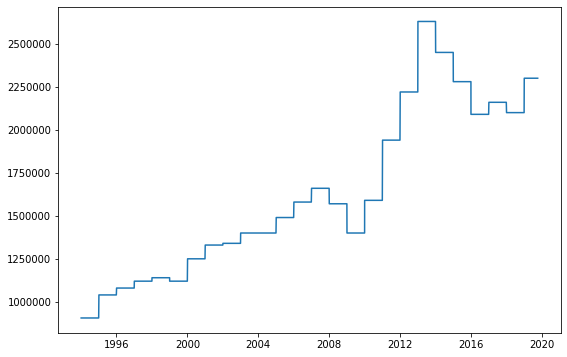

In [18]:
plt.plot(global_prod)

# Step 1 - Scrape New Nickel Data



# Step 2 - Preprocess Data


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [30]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [31]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [25]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled_china['GDP per capita growth (annual %)'], window_setting)
global_prod_stationary = preprocess(global_prod, window_setting)


rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''
df['lag18'] = df.lag0.shift(periods=26*lag_length)
df['lag19'] = df.lag0.shift(periods=29*lag_length)
df['lag20'] = df.lag0.shift(periods=32*lag_length)

df['lag21'] = df.lag0.shift(periods=35*lag_length)
df['lag22'] = df.lag0.shift(periods=38*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]
df['gdp'] = upsampled_stationary
df['global_prod'] = global_prod_stationary
df['week_of_year'] = df.index.weekofyear 
df['day_of_month'] = df.index.day
df['gdp_capita'] = upsampled_china['GDP per capita (current US$)']
df['gdp_capita_growth'] = upsampled_china['GDP per capita growth (annual %)']

df['consumption_exp'] = upsampled_china_consump['Final consumption expenditure (current US$)']
df['consumption_percent_gdp'] = upsampled_china_consump['Final consumption expenditure (% of GDP)']



df['y'] = df['lag0'].shift(-261)
df = df.dropna(subset=['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])

#df = df.dropna()
df.tail()

KeyError: 'Final consumption expenditure (current US$)'

In [28]:
upsampled_china_consump

,GDP per capita (current US$),GDP per capita growth (annual %)
index,,
1994-01-03,377.389839,12.566028
1994-01-04,377.389839,12.566028
1994-01-05,377.389839,12.566028
1994-01-06,377.389839,12.566028
1994-01-07,377.389839,12.566028
...,...,...
2019-10-01,9770.847088,6.115117
2019-10-02,9770.847088,6.115117
2019-10-03,9770.847088,6.115117


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

### GOAL: To run tests over last 10??? years to take a closer look at MAE's over different sliding windows -- To get a sense of the long term accuracy of the model - scenario evaluation

In [47]:
dates = df.index

In [48]:
dates

RangeIndex(start=1, stop=8027, step=1)

In [49]:
np.sqrt(261*15)

62.56996084384263

In [50]:
dates[dates<datetime.datetime(2002, 10, 2)][::5]

TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

In [23]:
import datetime

for item in dates[dates<datetime.datetime(2002, 10, 2)][::5]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    print(end_date_test)

2011-11-09 00:00:00
2011-11-16 00:00:00
2011-11-23 00:00:00
2011-11-30 00:00:00
2011-12-07 00:00:00
2011-12-14 00:00:00
2011-12-21 00:00:00
2011-12-28 00:00:00
2012-01-04 00:00:00
2012-01-11 00:00:00
2012-01-18 00:00:00
2012-01-25 00:00:00
2012-02-01 00:00:00
2012-02-08 00:00:00
2012-02-15 00:00:00
2012-02-22 00:00:00
2012-02-29 00:00:00
2012-03-07 00:00:00
2012-03-14 00:00:00
2012-03-21 00:00:00
2012-03-28 00:00:00
2012-04-04 00:00:00
2012-04-11 00:00:00
2012-04-18 00:00:00
2012-04-25 00:00:00
2012-05-02 00:00:00
2012-05-09 00:00:00
2012-05-16 00:00:00
2012-05-23 00:00:00
2012-05-30 00:00:00
2012-06-06 00:00:00
2012-06-13 00:00:00
2012-06-20 00:00:00
2012-06-27 00:00:00
2012-07-04 00:00:00
2012-07-11 00:00:00
2012-07-18 00:00:00
2012-07-25 00:00:00
2012-08-01 00:00:00
2012-08-08 00:00:00
2012-08-15 00:00:00
2012-08-22 00:00:00
2012-08-29 00:00:00
2012-09-05 00:00:00
2012-09-12 00:00:00
2012-09-19 00:00:00
2012-09-26 00:00:00
2012-10-03 00:00:00
2012-10-10 00:00:00
2012-10-17 00:00:00


In [104]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2001, 10, 2)][::5]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    X_train = train[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    
    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 59 , MAE: 2317.2491334921615
2010-11-10 00:00:00 , Optimal K: 59 , MAE: 2234.713697269696
2010-11-11 00:00:00 , Optimal K: 59 , MAE: 2162.751230904909
2010-11-12 00:00:00 , Optimal K: 59 , MAE: 2072.808980856789
2010-11-15 00:00:00 , Optimal K: 59 , MAE: 1990.2739707385792
2010-11-16 00:00:00 , Optimal K: 59 , MAE: 1878.3931038531023
2010-11-17 00:00:00 , Optimal K: 59 , MAE: 1846.5179902044244
2010-11-18 00:00:00 , Optimal K: 59 , MAE: 1815.004002920779
2010-11-19 00:00:00 , Optimal K: 59 , MAE: 1741.4137282306558
2010-11-22 00:00:00 , Optimal K: 59 , MAE: 1682.9791807612705
2010-11-23 00:00:00 , Optimal K: 59 , MAE: 1643.4164844783622
2010-11-24 00:00:00 , Optimal K: 59 , MAE: 1576.9212660757328
2010-11-25 00:00:00 , Optimal K: 59 , MAE: 1535.9068291442852
2010-11-26 00:00:00 , Optimal K: 59 , MAE: 1498.6893252926138
2010-11-29 00:00:00 , Optimal K: 59 , MAE: 1475.4412333499545
2010-11-30 00:00:00 , Optimal K: 59 , MAE: 1461.0986787467184
2010-12-01 0

2011-05-16 00:00:00 , Optimal K: 59 , MAE: 1382.7035158768865
2011-05-17 00:00:00 , Optimal K: 59 , MAE: 1330.3627670603694
2011-05-18 00:00:00 , Optimal K: 59 , MAE: 1294.1341523048588
2011-05-19 00:00:00 , Optimal K: 59 , MAE: 1280.3674076393008
2011-05-20 00:00:00 , Optimal K: 59 , MAE: 1244.1906090435477
2011-05-23 00:00:00 , Optimal K: 59 , MAE: 1245.623290761422
2011-05-24 00:00:00 , Optimal K: 59 , MAE: 1215.7366478909025
2011-05-25 00:00:00 , Optimal K: 59 , MAE: 1190.4921503380249
2011-05-26 00:00:00 , Optimal K: 59 , MAE: 1192.1315368557898
2011-05-27 00:00:00 , Optimal K: 59 , MAE: 1195.538843680914
2011-05-30 00:00:00 , Optimal K: 59 , MAE: 1203.5196036058232
2011-05-31 00:00:00 , Optimal K: 59 , MAE: 1179.4387678125067
2011-06-01 00:00:00 , Optimal K: 59 , MAE: 1153.4007161276704
2011-06-02 00:00:00 , Optimal K: 59 , MAE: 1133.2797418689477
2011-06-03 00:00:00 , Optimal K: 59 , MAE: 1112.437461628377
2011-06-06 00:00:00 , Optimal K: 59 , MAE: 1102.0052523537422
2011-06-07 

2011-11-17 00:00:00 , Optimal K: 59 , MAE: 1786.9247000188905
2011-11-18 00:00:00 , Optimal K: 59 , MAE: 1791.7886714065064
2011-11-21 00:00:00 , Optimal K: 55 , MAE: 1837.153805771072
2011-11-22 00:00:00 , Optimal K: 59 , MAE: 1882.2673991848603
2011-11-23 00:00:00 , Optimal K: 59 , MAE: 1933.9545787517034
2011-11-24 00:00:00 , Optimal K: 59 , MAE: 1985.012946479874
2011-11-25 00:00:00 , Optimal K: 59 , MAE: 2030.020658022513
2011-11-28 00:00:00 , Optimal K: 59 , MAE: 2072.0005891790643
2011-11-29 00:00:00 , Optimal K: 59 , MAE: 2139.5185784166924
2011-11-30 00:00:00 , Optimal K: 59 , MAE: 2211.7078375559995
2011-12-01 00:00:00 , Optimal K: 59 , MAE: 2275.98355983991
2011-12-02 00:00:00 , Optimal K: 59 , MAE: 2405.8774691266976
2011-12-05 00:00:00 , Optimal K: 59 , MAE: 2519.1220452438533
2011-12-06 00:00:00 , Optimal K: 59 , MAE: 2612.905214365236
2011-12-07 00:00:00 , Optimal K: 59 , MAE: 2695.6238125572922
2011-12-08 00:00:00 , Optimal K: 59 , MAE: 2744.9163867317525
2011-12-09 00:

2012-05-23 00:00:00 , Optimal K: 57 , MAE: 2135.1483990766565
2012-05-24 00:00:00 , Optimal K: 59 , MAE: 2158.7016746542276
2012-05-25 00:00:00 , Optimal K: 59 , MAE: 2194.5340623107913
2012-05-28 00:00:00 , Optimal K: 59 , MAE: 2236.195521093376
2012-05-29 00:00:00 , Optimal K: 59 , MAE: 2251.3080965290383
2012-05-30 00:00:00 , Optimal K: 59 , MAE: 2268.300345791284
2012-05-31 00:00:00 , Optimal K: 59 , MAE: 2290.3810534939025
2012-06-01 00:00:00 , Optimal K: 59 , MAE: 2326.643153867878
2012-06-04 00:00:00 , Optimal K: 1 , MAE: 2318.3631914937832
2012-06-05 00:00:00 , Optimal K: 59 , MAE: 2307.8374334753676
2012-06-06 00:00:00 , Optimal K: 1 , MAE: 2240.4564823422006
2012-06-07 00:00:00 , Optimal K: 1 , MAE: 2083.5065545157136
2012-06-08 00:00:00 , Optimal K: 1 , MAE: 2007.475582256527
2012-06-11 00:00:00 , Optimal K: 1 , MAE: 2044.4018072360795
2012-06-12 00:00:00 , Optimal K: 1 , MAE: 2188.9903485425075
2012-06-13 00:00:00 , Optimal K: 59 , MAE: 2446.7716988564375
2012-06-14 00:00:0

2012-11-28 00:00:00 , Optimal K: 1 , MAE: 3859.750705978063
2012-11-29 00:00:00 , Optimal K: 1 , MAE: 3792.068610898975
2012-11-30 00:00:00 , Optimal K: 1 , MAE: 3777.9785425323657
2012-12-03 00:00:00 , Optimal K: 1 , MAE: 3637.6911740774813
2012-12-04 00:00:00 , Optimal K: 1 , MAE: 3662.6660320267933
2012-12-05 00:00:00 , Optimal K: 1 , MAE: 3488.7346276783996
2012-12-06 00:00:00 , Optimal K: 1 , MAE: 3378.4264188505626
2012-12-07 00:00:00 , Optimal K: 1 , MAE: 3356.5699754121374
2012-12-10 00:00:00 , Optimal K: 1 , MAE: 3321.1563008572934
2012-12-11 00:00:00 , Optimal K: 1 , MAE: 3459.7248353784703
2012-12-12 00:00:00 , Optimal K: 1 , MAE: 3437.161628229167
2012-12-13 00:00:00 , Optimal K: 1 , MAE: 3290.416844509847
2012-12-14 00:00:00 , Optimal K: 1 , MAE: 3264.473831085673
2012-12-17 00:00:00 , Optimal K: 1 , MAE: 3250.7626216026815
2012-12-18 00:00:00 , Optimal K: 1 , MAE: 3165.294084512308
2012-12-19 00:00:00 , Optimal K: 1 , MAE: 3075.28840316226
2012-12-20 00:00:00 , Optimal K:

2013-06-05 00:00:00 , Optimal K: 55 , MAE: 7445.25161351392
2013-06-06 00:00:00 , Optimal K: 59 , MAE: 7312.299717747446
2013-06-07 00:00:00 , Optimal K: 59 , MAE: 7166.5591227667755
2013-06-10 00:00:00 , Optimal K: 59 , MAE: 7004.237000802946
2013-06-11 00:00:00 , Optimal K: 1 , MAE: 6737.704126267795
2013-06-12 00:00:00 , Optimal K: 1 , MAE: 3543.589158997416
2013-06-13 00:00:00 , Optimal K: 1 , MAE: 2329.7893290854786
2013-06-14 00:00:00 , Optimal K: 1 , MAE: 2345.3014056610605
2013-06-17 00:00:00 , Optimal K: 1 , MAE: 2640.7475317915028
2013-06-18 00:00:00 , Optimal K: 1 , MAE: 3007.6888295607196
2013-06-19 00:00:00 , Optimal K: 1 , MAE: 2701.16521806368
2013-06-20 00:00:00 , Optimal K: 1 , MAE: 2693.6949483987214
2013-06-21 00:00:00 , Optimal K: 1 , MAE: 2438.816478300002
2013-06-24 00:00:00 , Optimal K: 1 , MAE: 2382.1136381498695
2013-06-25 00:00:00 , Optimal K: 1 , MAE: 2183.8279695459046
2013-06-26 00:00:00 , Optimal K: 1 , MAE: 2364.7596705154274
2013-06-27 00:00:00 , Optimal

2013-12-12 00:00:00 , Optimal K: 15 , MAE: 3254.421587077182
2013-12-13 00:00:00 , Optimal K: 15 , MAE: 3375.4707711093424
2013-12-16 00:00:00 , Optimal K: 19 , MAE: 3444.0915561449574
2013-12-17 00:00:00 , Optimal K: 19 , MAE: 3377.430732354741
2013-12-18 00:00:00 , Optimal K: 17 , MAE: 3252.2267833248125
2013-12-19 00:00:00 , Optimal K: 19 , MAE: 3084.018470768407
2013-12-20 00:00:00 , Optimal K: 19 , MAE: 2873.914274010141
2013-12-23 00:00:00 , Optimal K: 19 , MAE: 2808.9028429816935
2013-12-24 00:00:00 , Optimal K: 21 , MAE: 2677.162905219648
2013-12-25 00:00:00 , Optimal K: 21 , MAE: 2556.3563443108096
2013-12-26 00:00:00 , Optimal K: 23 , MAE: 2464.647902869167
2013-12-27 00:00:00 , Optimal K: 23 , MAE: 2382.626338954807
2013-12-30 00:00:00 , Optimal K: 23 , MAE: 2205.5032837737904
2013-12-31 00:00:00 , Optimal K: 23 , MAE: 2020.906874152876
2014-01-01 00:00:00 , Optimal K: 23 , MAE: 1870.6305551194014
2014-01-02 00:00:00 , Optimal K: 1 , MAE: 1475.7302244436676
2014-01-03 00:00:

2014-06-19 00:00:00 , Optimal K: 59 , MAE: 1505.22367865902
2014-06-20 00:00:00 , Optimal K: 59 , MAE: 1512.8587404008838
2014-06-23 00:00:00 , Optimal K: 59 , MAE: 1489.7928951093595
2014-06-24 00:00:00 , Optimal K: 59 , MAE: 1520.553425765399
2014-06-25 00:00:00 , Optimal K: 59 , MAE: 1532.7880548492228
2014-06-26 00:00:00 , Optimal K: 59 , MAE: 1531.5105228123782
2014-06-27 00:00:00 , Optimal K: 59 , MAE: 1515.0873525099992
2014-06-30 00:00:00 , Optimal K: 57 , MAE: 1427.9159972954474
2014-07-01 00:00:00 , Optimal K: 59 , MAE: 1357.1851941723196
2014-07-02 00:00:00 , Optimal K: 59 , MAE: 1322.001907152294
2014-07-03 00:00:00 , Optimal K: 59 , MAE: 1296.1654622448673
2014-07-04 00:00:00 , Optimal K: 59 , MAE: 1269.6403531416195
2014-07-07 00:00:00 , Optimal K: 59 , MAE: 1226.5629372342798
2014-07-08 00:00:00 , Optimal K: 59 , MAE: 1131.7104425083999
2014-07-09 00:00:00 , Optimal K: 59 , MAE: 1070.9958341542815
2014-07-10 00:00:00 , Optimal K: 59 , MAE: 1052.293705303321
2014-07-11 00

2014-12-24 00:00:00 , Optimal K: 41 , MAE: 3774.3293931710195
2014-12-25 00:00:00 , Optimal K: 41 , MAE: 3787.2893215079753
2014-12-26 00:00:00 , Optimal K: 41 , MAE: 3808.2042944381656
2014-12-29 00:00:00 , Optimal K: 41 , MAE: 3812.779783261937
2014-12-30 00:00:00 , Optimal K: 41 , MAE: 3808.3598921664825
2014-12-31 00:00:00 , Optimal K: 41 , MAE: 3806.619964301524
2015-01-01 00:00:00 , Optimal K: 41 , MAE: 3767.5081675126776
2015-01-02 00:00:00 , Optimal K: 1 , MAE: 3493.1642352829513
2015-01-05 00:00:00 , Optimal K: 1 , MAE: 3835.8912949497562
2015-01-06 00:00:00 , Optimal K: 1 , MAE: 3799.8456637793824
2015-01-07 00:00:00 , Optimal K: 1 , MAE: 3713.07685468057
2015-01-08 00:00:00 , Optimal K: 1 , MAE: 3845.8569034658512
2015-01-09 00:00:00 , Optimal K: 1 , MAE: 3822.7974628419433
2015-01-12 00:00:00 , Optimal K: 1 , MAE: 4087.7507652862073
2015-01-13 00:00:00 , Optimal K: 1 , MAE: 4123.57269970572
2015-01-14 00:00:00 , Optimal K: 1 , MAE: 4002.1116075990267
2015-01-15 00:00:00 , O

2015-07-01 00:00:00 , Optimal K: 59 , MAE: 3341.091009033807
2015-07-02 00:00:00 , Optimal K: 59 , MAE: 3298.138391608883
2015-07-03 00:00:00 , Optimal K: 59 , MAE: 3202.640578659972
2015-07-06 00:00:00 , Optimal K: 59 , MAE: 3099.6337378901912
2015-07-07 00:00:00 , Optimal K: 59 , MAE: 3063.987089874527
2015-07-08 00:00:00 , Optimal K: 59 , MAE: 2999.6655224186334
2015-07-09 00:00:00 , Optimal K: 59 , MAE: 2962.8785370531286
2015-07-10 00:00:00 , Optimal K: 59 , MAE: 2886.7019289464884
2015-07-13 00:00:00 , Optimal K: 59 , MAE: 2796.956622398648
2015-07-14 00:00:00 , Optimal K: 59 , MAE: 2671.7446380468095
2015-07-15 00:00:00 , Optimal K: 59 , MAE: 2480.0700133541113
2015-07-16 00:00:00 , Optimal K: 59 , MAE: 2278.698353877794
2015-07-17 00:00:00 , Optimal K: 59 , MAE: 2129.2533523924326
2015-07-20 00:00:00 , Optimal K: 1 , MAE: 1554.7385410063807
2015-07-21 00:00:00 , Optimal K: 1 , MAE: 1596.7577932046395
2015-07-22 00:00:00 , Optimal K: 59 , MAE: 1622.1063430219497
2015-07-23 00:00

2016-01-05 00:00:00 , Optimal K: 59 , MAE: 1941.782154399914
2016-01-06 00:00:00 , Optimal K: 59 , MAE: 1993.0922961607623
2016-01-07 00:00:00 , Optimal K: 59 , MAE: 2045.4663574675485
2016-01-08 00:00:00 , Optimal K: 59 , MAE: 2116.011074188961
2016-01-11 00:00:00 , Optimal K: 59 , MAE: 2180.5929267052925
2016-01-12 00:00:00 , Optimal K: 59 , MAE: 2234.558812752592
2016-01-13 00:00:00 , Optimal K: 59 , MAE: 2313.52294393876
2016-01-14 00:00:00 , Optimal K: 59 , MAE: 2378.6494157101124
2016-01-15 00:00:00 , Optimal K: 59 , MAE: 2406.7876222486275
2016-01-18 00:00:00 , Optimal K: 59 , MAE: 2441.133785480935
2016-01-19 00:00:00 , Optimal K: 59 , MAE: 2478.0258585288343
2016-01-20 00:00:00 , Optimal K: 59 , MAE: 2510.6808843352087
2016-01-21 00:00:00 , Optimal K: 59 , MAE: 2556.988886835432
2016-01-22 00:00:00 , Optimal K: 59 , MAE: 2615.8857568810054
2016-01-25 00:00:00 , Optimal K: 59 , MAE: 2670.3060118982175
2016-01-26 00:00:00 , Optimal K: 59 , MAE: 2711.5027685743958
2016-01-27 00:0

2016-07-11 00:00:00 , Optimal K: 59 , MAE: 5517.208129173093
2016-07-12 00:00:00 , Optimal K: 59 , MAE: 5496.713676326456
2016-07-13 00:00:00 , Optimal K: 1 , MAE: 5286.577483727705
2016-07-14 00:00:00 , Optimal K: 1 , MAE: 5250.764646057277
2016-07-15 00:00:00 , Optimal K: 1 , MAE: 5191.557585957015
2016-07-18 00:00:00 , Optimal K: 1 , MAE: 4835.573324432767
2016-07-19 00:00:00 , Optimal K: 1 , MAE: 4733.986538765788
2016-07-20 00:00:00 , Optimal K: 1 , MAE: 4725.668160536561
2016-07-21 00:00:00 , Optimal K: 1 , MAE: 4706.976678087655
2016-07-22 00:00:00 , Optimal K: 1 , MAE: 4729.598242781978
2016-07-25 00:00:00 , Optimal K: 1 , MAE: 4706.555651391218
2016-07-26 00:00:00 , Optimal K: 1 , MAE: 4461.77046277257
2016-07-27 00:00:00 , Optimal K: 1 , MAE: 4030.052425582655
2016-07-28 00:00:00 , Optimal K: 1 , MAE: 3951.2712713710757
2016-07-29 00:00:00 , Optimal K: 1 , MAE: 3962.5297934221917
2016-08-01 00:00:00 , Optimal K: 1 , MAE: 3911.396118133337
2016-08-02 00:00:00 , Optimal K: 1 , 

2017-01-16 00:00:00 , Optimal K: 23 , MAE: 1097.2968302802694
2017-01-17 00:00:00 , Optimal K: 21 , MAE: 1107.0757908492474
2017-01-18 00:00:00 , Optimal K: 21 , MAE: 1122.5184741032647
2017-01-19 00:00:00 , Optimal K: 21 , MAE: 1134.8004574028837
2017-01-20 00:00:00 , Optimal K: 21 , MAE: 1141.9906481581413
2017-01-23 00:00:00 , Optimal K: 21 , MAE: 1146.5327919193408
2017-01-24 00:00:00 , Optimal K: 21 , MAE: 1149.059336956905
2017-01-25 00:00:00 , Optimal K: 21 , MAE: 1129.2530527688964
2017-01-26 00:00:00 , Optimal K: 21 , MAE: 1110.2252249306407
2017-01-27 00:00:00 , Optimal K: 21 , MAE: 1096.5088796219836
2017-01-30 00:00:00 , Optimal K: 21 , MAE: 1078.5944027979765
2017-01-31 00:00:00 , Optimal K: 21 , MAE: 1071.3316930507333
2017-02-01 00:00:00 , Optimal K: 23 , MAE: 1058.8282011242677
2017-02-02 00:00:00 , Optimal K: 23 , MAE: 1044.8584374736627
2017-02-03 00:00:00 , Optimal K: 23 , MAE: 1044.1373980132475
2017-02-06 00:00:00 , Optimal K: 23 , MAE: 1049.1044164841576
2017-02-0

2017-07-21 00:00:00 , Optimal K: 1 , MAE: 1089.8206349981735
2017-07-24 00:00:00 , Optimal K: 1 , MAE: 1086.1658680020255
2017-07-25 00:00:00 , Optimal K: 1 , MAE: 1059.015162502091
2017-07-26 00:00:00 , Optimal K: 1 , MAE: 1135.5711599477982
2017-07-27 00:00:00 , Optimal K: 1 , MAE: 1199.7929396660113
2017-07-28 00:00:00 , Optimal K: 1 , MAE: 1220.0204029012411
2017-07-31 00:00:00 , Optimal K: 1 , MAE: 1196.5251340518007
2017-08-01 00:00:00 , Optimal K: 23 , MAE: 1303.63376909642
2017-08-02 00:00:00 , Optimal K: 1 , MAE: 1246.7397246247417
2017-08-03 00:00:00 , Optimal K: 1 , MAE: 1175.2183792399196
2017-08-04 00:00:00 , Optimal K: 1 , MAE: 1216.7800136944697
2017-08-07 00:00:00 , Optimal K: 23 , MAE: 1265.069919652896
2017-08-08 00:00:00 , Optimal K: 23 , MAE: 1301.7814532571963
2017-08-09 00:00:00 , Optimal K: 23 , MAE: 1379.1996718580654
2017-08-10 00:00:00 , Optimal K: 23 , MAE: 1414.5952361754119
2017-08-11 00:00:00 , Optimal K: 23 , MAE: 1454.0080619899522
2017-08-14 00:00:00 , 

In [105]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
# FOUR FEATURES 
df_results.to_csv('final_consumptionperdiv_weekofyr_globalprod_gdppercap.csv')



## Build Final Model


Take a look at previous error rates over the last few years

In [227]:
def try_out_model(start_date_test, df):
    '''Inputs start date of TESTING PERIOD and outputs training and testing data sets'''

    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    #start_date = datetime.datetime(2018, 10, 3) -  pd.tseries.offsets.BusinessDay(16*261)

    #end_date = start_date+train_offset
    end_date = start_date_test - pd.tseries.offsets.BusinessDay(n=1)
    start_date = end_date-train_offset

    start_date_test
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset

    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    test = test.dropna() # incase train test split don't always add up 

    #print('Train Start: ', start_date)
    #print('Train End: ', end_date)
    #print('Test Start: ', start_date_test)
    #print('Test End: ', end_date_test)
    
    train = df.loc[start_date:end_date, :]  
    #test = df[df['y'].isna() == True]
    test = df.loc[start_date_test:end_date_test, :]
    return train, test

def preprocess_sets(train, test):

    '''
    X_train = train[['consumption_percent_gdp', 'week_of_year', 'global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                         'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'week_of_year', 'global_prod' ,'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    '''
    
    X_train = train[['consumption_percent_gdp', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                         'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp' ,'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    
    
    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)

    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)

    return X_train, X_test, y_train, y_test


today = datetime.datetime(2019, 10, 7)
train, test = try_out_model(today-pd.tseries.offsets.BusinessDay(n=261), df)


In [228]:
def k_optimizer(shifted_start_date_end12th, df):
    k_params_listed = []

    for i in range(13):

        '''Function that takes the end of the training period with most common K's and then uses that. '''
        train, test = train, test = try_out_model(shifted_start_date_end12th-pd.tseries.offsets.BusinessDay(n=12-i), df)
        X_train, X_test, y_train, y_test = preprocess_sets(train, test)

        
        for K in range(0, 60, 2):
            K = K+1
            regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

            regressor.fit(X_train, y_train)
            #print(regressor.coef_)

            y_pred = regressor.predict(X_test)
            y_pred = pd.Series(y_pred)
            y_pred.index = y_test.index


            original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

            for key, item in y_pred.items():
                rolling_avg = original_tail.tail(window_setting).mean()
                unscaled_result = item+rolling_avg
                original_tail = original_tail.append(pd.Series([unscaled_result]))

            unscaled = pd.Series(original_tail)
            unscaled = unscaled[window_setting:]
            unscaled.index = y_test.index

            original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

            for key, item in y_test.items():
                rolling_avg = original_tail.tail(window_setting).mean()
                original_y = item+rolling_avg
                original_tail = original_tail.append(pd.Series([original_y]))


            original_y = pd.Series(original_tail)
            original_y = original_y[window_setting:]
            original_y.index = y_test.index

            mae = metrics.mean_absolute_error(original_y, unscaled)

            #print('kfold test accuracy =', kfold_test_accuracy)
            cv_results[str(K)] = mae



        cv_results_series = pd.Series(list(cv_results.values()))
        cv_results_series.index = cv_results.keys()
        min_test_accuracy = cv_results_series.min()
        min_parameters = cv_results_series.idxmin()
        
        k_params_listed.append(int(min_parameters))
    array = np.array(k_params_listed)
    return round(array.mean())
    

In [233]:
# SET NEW START DATE OF TEST SET TO ASSESS
# NOTE: Try 2016-10-5! 
start_date_test = datetime.datetime(2017, 10, 5)


best_k:  57.0


TypeError: unsupported operand type(s) for +: 'float' and 'relativedelta'

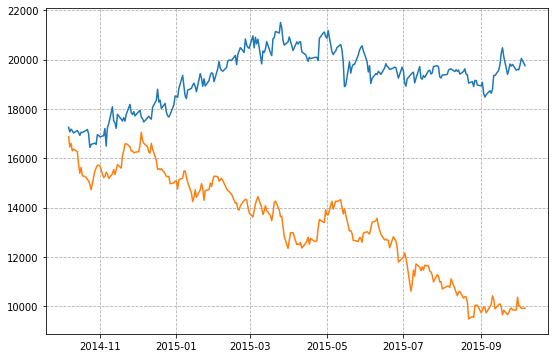

In [243]:
for item in [datetime.datetime(2013, 10, 5), datetime.datetime(2014, 10, 5), datetime.datetime(2015, 10, 5), datetime.datetime(2016, 10, 5), datetime.datetime(2017, 10, 5)]:
    '''Organize/transforms the data'''
    train, test = train, test = try_out_model(item, df)
    X_train, X_test, y_train, y_test = preprocess_sets(train, test)
    '''Selects a K by looking at data fit over 15 years but starting ONE YEAR BEFORE current training data'''

    best_k = k_optimizer(item-pd.tseries.offsets.BusinessDay(n=261), df)
    print('best_k: ', best_k)
    cv_results={}

    K = int(best_k)
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]


    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index

    #mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    #cv_results[str(K)] = mae



    #cv_results_series = pd.Series(list(cv_results.values()))
    #cv_results_series.index = cv_results.keys()
    #min_test_accuracy = cv_results_series.min()
    #min_parameters = cv_results_series.idxmin()

    results = unscaled.copy()
    results.index = results.index + pd.DateOffset(years=1)


    unscaled_results = unscaled.copy()
    unscaled_results.index = unscaled_results.index + pd.DateOffset(years=1)
    original_y_results = original_y.copy()
    original_y_results.index = original_y_results.index + pd.DateOffset(years=1)


    plt.plot(unscaled_results)
    plt.plot(original_y_results)

    plt.grid(linestyle='dashed')
    plt.title('Test Results ' + str(item + pd.DateOffset(years=1)), fontsize=15)
    plt.show()

    mae = metrics.mean_absolute_error(original_y_results, unscaled_results)
    print('MAE for this test period:', mae)


    # FIT ON TRAINING DATA 

    y_pred_train  = regressor.predict(X_train)
    y_pred_train = pd.Series(y_pred_train)
    y_pred_train.index = y_train.index


    original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]
    original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
    original_y_train.index = y_train[window_setting:].index

    y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
    y_pred_train_unscaled.index = y_train[window_setting:].index



    plt.plot(y_pred_train_unscaled)
    plt.plot(original_y_train)
    plt.legend(['y_hat', 'y'])
    plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
    filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

    #plt.savefig(filename)
    plt.show()



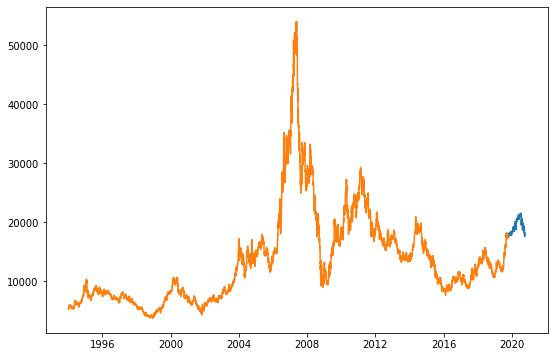

In [65]:
plt.plot(results)
plt.plot(LME)

In [56]:
test = pd.DataFrame({'date': results.index, 'results': results})
LME_test = pd.DataFrame({'date': LME.index, 'results': LME})
LME_test = LME_test[LME_test.index.year>2013]

MAE = pd.read_csv('results/CV Results/15_yr_training/final_consumptionperdiv_weekofyr_globalprod_gdppercap.csv')

MAE['Unnamed: 0'] = pd.to_datetime(MAE['Unnamed: 0'])

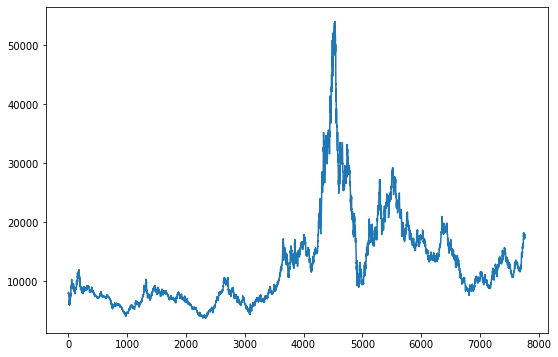

In [18]:
df = pd.read_csv('results/Forecasts/forecasts_2019-11-25.csv')
df= df.iloc[1:, :]
df
plt.plot(df['Actual Price'])

In [139]:
# To save prediction results to a pickle file

from datetime import datetime
now = datetime.now()

timestamp = datetime.timestamp(now)
timestamp = datetime.fromtimestamp(timestamp)

# To save as a csv data type
results.to_csv('forecasts_'+str(timestamp)[:10] + '.csv', header=True)

print(timestamp)

2019-11-25 14:46:04.995302


TypeError: 'module' object is not callable

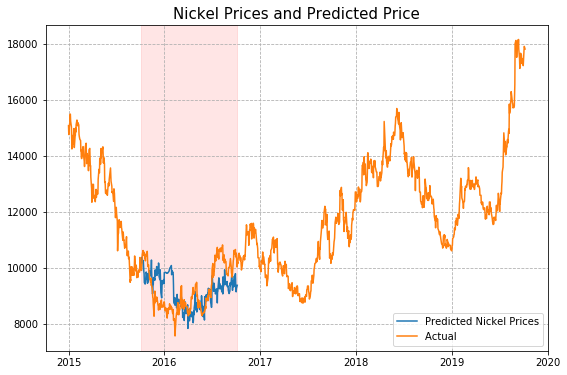

In [119]:
plt.plot(results)
plt.plot(LME[LME.index.year > 2014])

#plt.plot(LME)


plt.grid(linestyle='dashed')
plt.legend(['Predicted Nickel Prices', 'Actual '])
plt.axvspan(results.index[0], results.index[-1], alpha=0.1, color='red')
plt.title('Nickel Prices and Predicted Price', fontsize=15)

plt.axvline(datetime(2019, 10, 8), color='r', linestyle='dotted')


plt.show()


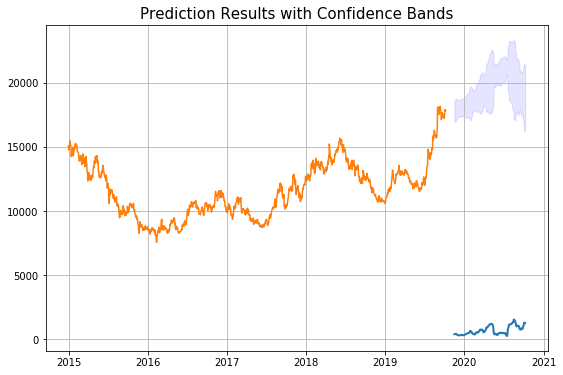

In [149]:
time_series_df = pd.DataFrame(results)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(path_deviation, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.plot(LME[LME.index.year > 2014])

plt.show()

## Next Task: Create Visualizations for Predicted and previous values 

In [59]:
y_pred = unscaled

print(y_pred)


#y_lower = np.percentile(y_pred, 10)

#print(y_lower)
#y_higher = np.percentile(y_Pred, 90)
#y_mid = np.percentile(y_pred, 50)

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
                  ...     
2019-08-27    18386.798281
2019-08-28    18548.640353
2019-08-29    18242.916031
2019-08-30    17652.135329
2019-09-02    17949.180479
2019-09-03    17876.24239

In [39]:
# Confidence Interval Time Series From tutorial https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12

# Bootstrapping TUtorial Statistics
# https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/bootstrap-confidence-intervals?ex=5

n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

#conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})
conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})


In [44]:
print(bootstrap_means)

[[18456.84378109 18456.84378109 18456.84378109 ... 18456.84378109
  18456.84378109 18456.84378109]
 [18461.94082895 18461.94082895 18461.94082895 ... 18461.94082895
  18461.94082895 18461.94082895]
 [18590.67147797 18590.67147797 18590.67147797 ... 18590.67147797
  18590.67147797 18590.67147797]
 ...
 [18459.25407789 18459.25407789 18459.25407789 ... 18459.25407789
  18459.25407789 18459.25407789]
 [18529.62445989 18529.62445989 18529.62445989 ... 18529.62445989
  18529.62445989 18529.62445989]
 [18570.15957174 18570.15957174 18570.15957174 ... 18570.15957174
  18570.15957174 18570.15957174]]


In [37]:
n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    print('random sample: ', random_sample)
    print()
    print('calculated mean', random_sample.mean(axis=0))
    print()

random sample:  ds
2018-11-28    17625.593422
2019-02-27    18356.570512
2019-01-29    18358.778301
2019-02-25    19034.772323
2018-12-31    18046.456536
2019-09-20    17549.608819
2018-12-13    18468.833320
2019-07-10    19789.626166
2018-11-29    18170.158469
2019-08-22    17548.826393
2019-05-30    19447.173936
2019-08-21    17887.554343
2019-09-09    18080.648368
2019-03-15    18480.482787
2018-10-11    17494.281269
2019-02-12    18403.477579
2019-02-11    18602.477223
2019-06-28    20132.671710
2018-12-06    18010.799320
2019-03-29    18336.212843
2019-05-02    19321.039420
2019-02-07    18691.143417
2019-06-06    19718.558893
2019-05-23    19395.219011
2019-09-23    17331.690037
2019-04-29    19082.124611
2019-01-25    18784.746840
2019-02-12    18403.477579
2019-02-26    18858.522699
2019-09-16    17538.842278
                  ...     
2019-06-05    19759.973145
2018-11-12    17497.611747
2019-04-17    19170.780500
2019-06-11    19867.582422
2019-09-24    17284.894348
2019-06-2


random sample:  ds
2019-07-12    19982.504484
2019-07-25    18394.101326
2019-04-12    18985.278629
2019-01-15    18497.854885
2019-03-26    18742.749200
2019-03-14    18378.962986
2019-02-19    18694.148427
2019-07-01    20287.408751
2019-07-09    19792.634979
2019-09-30    16413.433836
2019-09-13    17389.691705
2019-08-14    17528.843131
2019-08-16    17430.142103
2019-03-29    18336.212843
2018-12-03    18180.276105
2019-09-12    17660.225321
2018-10-10    17574.645398
2018-11-27    18371.351862
2019-01-29    18358.778301
2019-01-21    18563.399146
2019-07-08    20452.302151
2019-07-29    18847.099827
2019-05-13    19488.879305
2019-07-25    18394.101326
2019-01-04    18461.616093
2018-10-30    17714.567286
2019-04-15    18882.258251
2018-11-08    17396.596678
2018-12-04    18029.378041
2019-07-29    18847.099827
                  ...     
2019-06-04    19836.085132
2019-01-24    18755.643119
2019-09-10    17798.327390
2019-08-05    19115.069366
2018-10-23    17630.692828
2018-10-

In [35]:
bootstrap_means = np.zeros((n_boots, len(y_pred)))
bootstrap_means.shape

(100, 261)

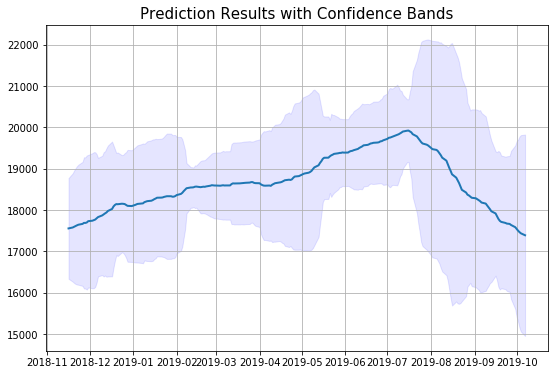

In [25]:
# From https://stackoverflow.com/questions/50161140/how-to-plot-a-time-series-array-with-confidence-intervals-displayed-in-python

time_series_df = pd.DataFrame(y_pred)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.show()

In [44]:
for date in dates:
    print(date)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


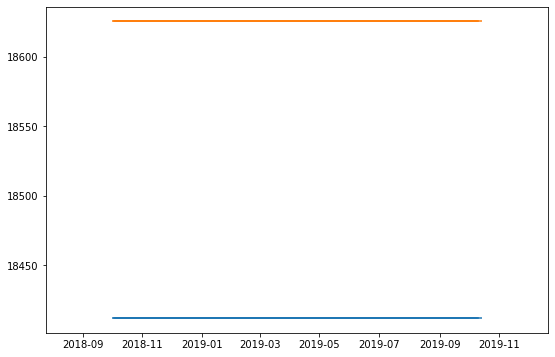

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_pred.index, percentiles[0], marker='_', s=200)
ax.scatter(y_pred.index, percentiles[1], marker='_', s=200)

In [30]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]
# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]
# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)



fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])
# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

NameError: name 'cv' is not defined

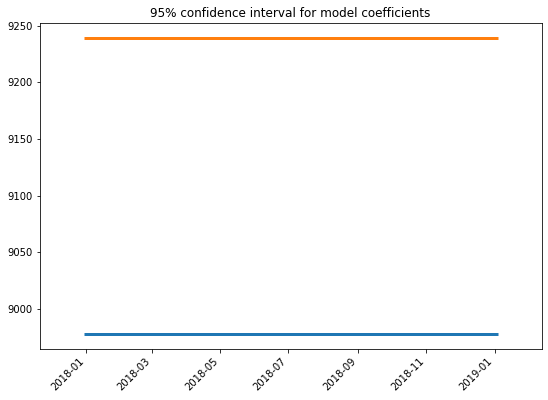

In [93]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(y_pred)

# Plot it
fig, ax = plt.subplots()
ax.scatter(y_pred.index, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(y_pred.index, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
# bootstrap for mean
boot_means = []
for _ in range(100):
    bootsample = np.random.choice(sample,size=30, replace=True)
    boot_means.append(bootsample.mean())